In [1]:
# Cell 1: Load and Prepare
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load preprocessed control cells
adata = sc.read_h5ad('../data/processed/sciplex_control_dose0_24h.h5ad')

print(f"Analyzing {adata.n_obs} control cells")
print(f"Cell lines: {adata.obs['cell_line'].value_counts()}")

# Use only HVGs for dimensionality reduction
adata_hvg = adata[:, adata.var['highly_variable']].copy()
print(f"\nUsing {adata_hvg.n_vars} highly variable genes")

# Scale data
sc.pp.scale(adata_hvg, max_value=10)
print("✓ Data scaled")

Analyzing 15472 control cells
Cell lines: cell_line
MCF7    7774
K562    3927
A549    3771
Name: count, dtype: int64

Using 3000 highly variable genes


/usr/lib/python3.12/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✓ Data scaled


/tmp/ipykernel_592/3014749005.py:5: FutureWarning: Argument `save` is deprecated and will be removed in a future version. Use `sc.pl.plot(show=False).figure.savefig()` instead.
  sc.pl.pca_variance_ratio(adata_hvg, n_pcs=50, save='_control_variance.png')


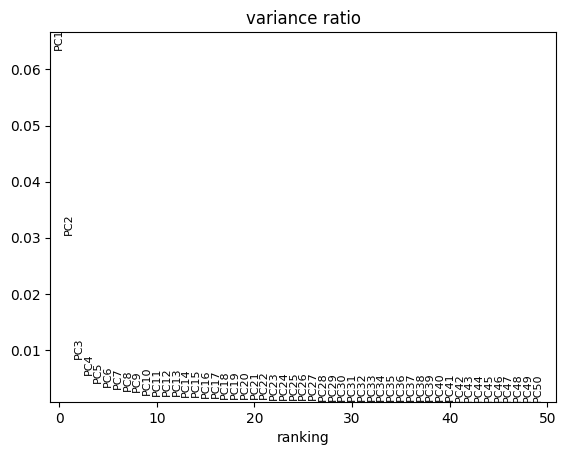

✓ PCA complete
Variance explained by PC1-30: 15.24%


In [2]:
# Cell 2: PCA
sc.tl.pca(adata_hvg, n_comps=50, svd_solver='arpack')

# Plot variance explained
sc.pl.pca_variance_ratio(adata_hvg, n_pcs=50, save='_control_variance.png')

print(f"✓ PCA complete")
print(f"Variance explained by PC1-30: {adata_hvg.uns['pca']['variance_ratio'][:30].sum():.2%}")

In [3]:
# Cell 3: Neighbors and UMAP
sc.pp.neighbors(adata_hvg, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata_hvg, min_dist=0.5)

print("✓ UMAP computed")

/home/kirandeav/projects/drug-response-predictor/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ UMAP computed


In [4]:
# Cell 4: Clustering
sc.tl.leiden(adata_hvg, resolution=0.5, key_added='leiden_r05')
sc.tl.leiden(adata_hvg, resolution=1.0, key_added='leiden_r10')

print(f"✓ Clustering complete")
print(f"Resolution 0.5: {adata_hvg.obs['leiden_r05'].nunique()} clusters")
print(f"Resolution 1.0: {adata_hvg.obs['leiden_r10'].nunique()} clusters")

/tmp/ipykernel_592/4133687809.py:2: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(adata_hvg, resolution=0.5, key_added='leiden_r05')
/tmp/ipykernel_592/4133687809.py:3: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(adata_hvg, resolution=1.0, key_added=

✓ Clustering complete
Resolution 0.5: 7 clusters
Resolution 1.0: 17 clusters


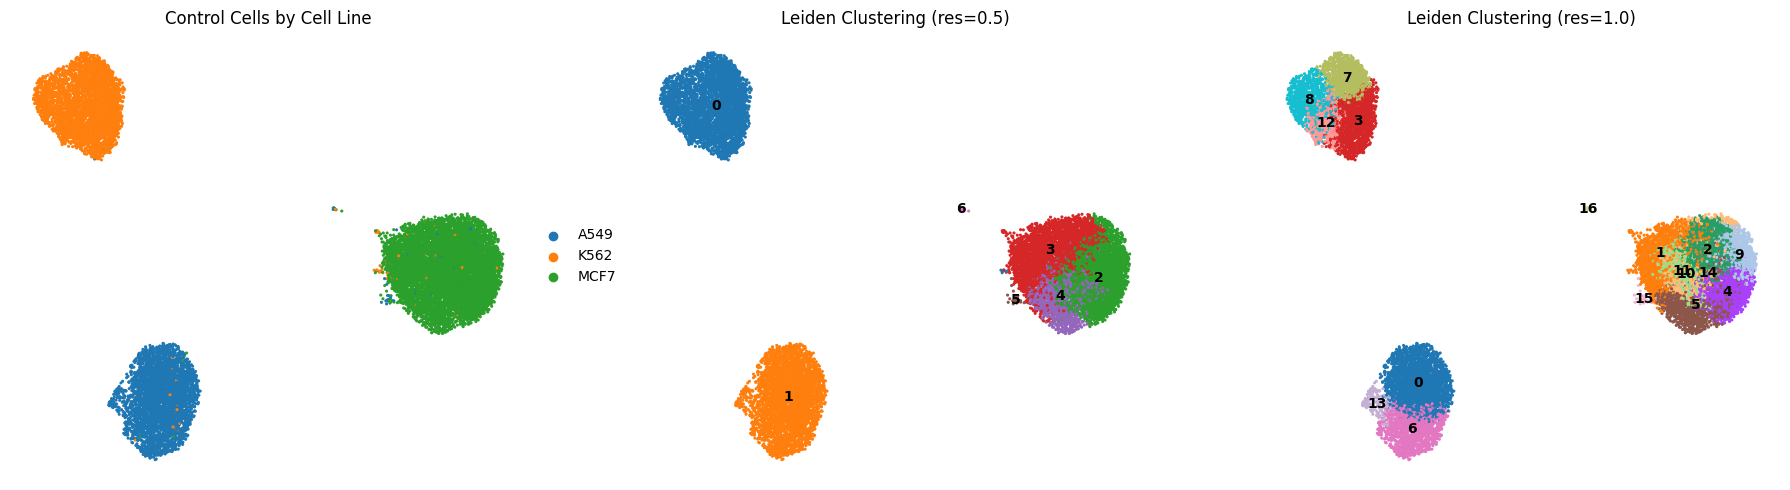


✓ UMAP saved to figures/03_control_umap_clustering.png


In [5]:
# Cell 5: Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# UMAP colored by cell line
sc.pl.umap(adata_hvg, color='cell_line', ax=axes[0], show=False, 
           title='Control Cells by Cell Line', frameon=False, size=20)

# UMAP colored by leiden (res=0.5)
sc.pl.umap(adata_hvg, color='leiden_r05', ax=axes[1], show=False,
           title='Leiden Clustering (res=0.5)', frameon=False, size=20, legend_loc='on data')

# UMAP colored by leiden (res=1.0)
sc.pl.umap(adata_hvg, color='leiden_r10', ax=axes[2], show=False,
           title='Leiden Clustering (res=1.0)', frameon=False, size=20, legend_loc='on data')

plt.tight_layout()
plt.savefig('../figures/03_control_umap_clustering.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ UMAP saved to figures/03_control_umap_clustering.png")

/tmp/ipykernel_592/2190408862.py:5: FutureWarning: Argument `save` is deprecated and will be removed in a future version. Use `sc.pl.plot(show=False).figure.savefig()` instead.
  sc.pl.rank_genes_groups(adata_hvg, n_genes=20, sharey=False,


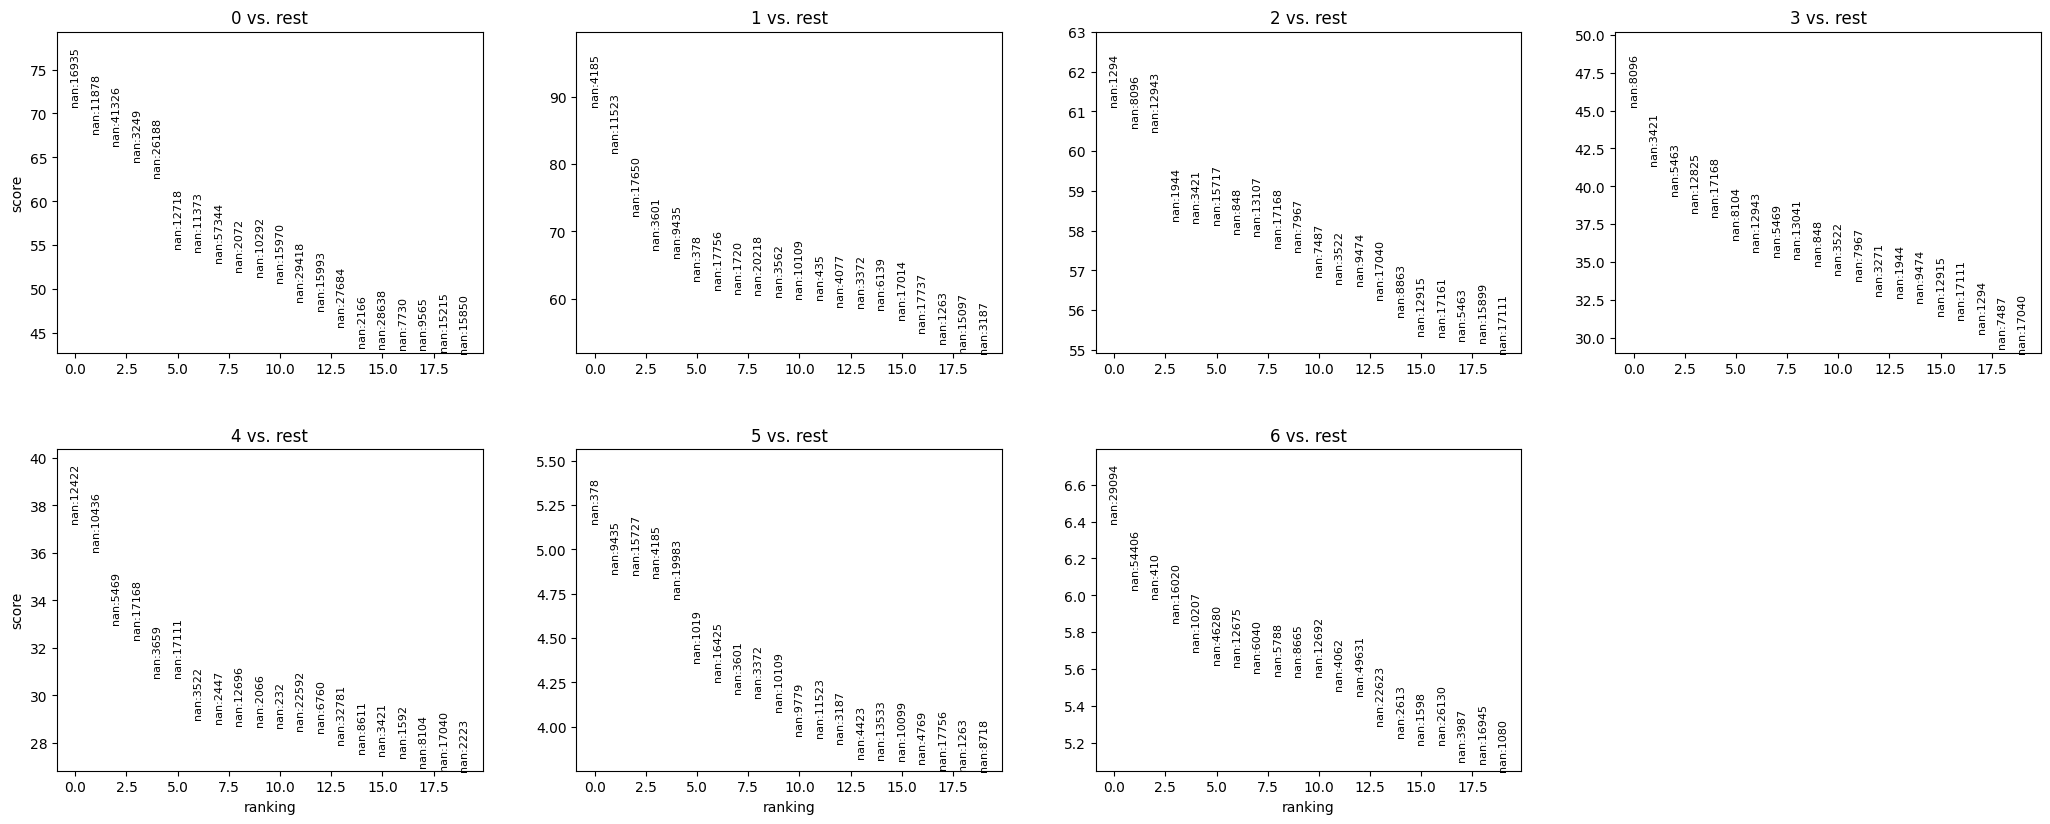

/tmp/ipykernel_592/2190408862.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  markers_top = markers.groupby('group').head(10)



Top 10 marker genes per cluster:
       group      names     scores  pvals_adj
0          0  nan:16935  70.884964   0.000000
1          0  nan:11878  67.732269   0.000000
2          0  nan:41326  66.418816   0.000000
3          0   nan:3249  64.533768   0.000000
4          0  nan:26188  62.739281   0.000000
...      ...        ...        ...        ...
133835     6  nan:46280   5.625988   0.000043
133836     6  nan:12675   5.613024   0.000043
133837     6   nan:6040   5.579675   0.000043
133838     6   nan:5788   5.565339   0.000043
133839     6   nan:8665   5.562147   0.000043

[70 rows x 4 columns]

✓ Marker genes saved
✓ Clustered data saved


In [6]:
# Cell 6: Find Marker Genes
sc.tl.rank_genes_groups(adata_hvg, 'leiden_r05', method='wilcoxon')

# Plot top markers
sc.pl.rank_genes_groups(adata_hvg, n_genes=20, sharey=False, 
                        save='_control_markers.png')

# Get marker table
markers = sc.get.rank_genes_groups_df(adata_hvg, group=None)
markers_top = markers.groupby('group').head(10)

print("\nTop 10 marker genes per cluster:")
print(markers_top[['group', 'names', 'scores', 'pvals_adj']])

# Save markers
markers.to_csv('../data/processed/control_cluster_markers_leiden05.csv', index=False)

# Save clustered data
adata_hvg.write_h5ad('../data/processed/sciplex_control_clustered.h5ad')

print("\n✓ Marker genes saved")
print("✓ Clustered data saved")

In [11]:
import scanpy as sc
import pandas as pd

# Load clustered data
adata = sc.read_h5ad('../data/processed/sciplex_control_clustered.h5ad')

print("Current gene name structure:")
print(adata.var.head())
print(f"\nTotal genes: {adata.n_vars}")
print(f"Index values: {adata.var.index[:5].tolist()}")

# Get marker genes
markers = sc.get.rank_genes_groups_df(adata, group=None)

print(f"\nMarker table shape: {markers.shape}")
print("Sample marker names:")
print(markers['names'].head(20))

# Create a mapping: gene_index → ensembl_id
# The 'names' column contains the index values (nan:XXX)
# We need to map these back to actual gene info

# Create mapping dictionary
gene_name_to_ensembl = dict(zip(adata.var.index, adata.var['ensembl_id']))

# Map marker names to Ensembl IDs
markers['ensembl_id'] = markers['names'].map(gene_name_to_ensembl)

# Also try to get gene symbols where they exist
# First, check if there's a gene_short_name column with actual symbols
if 'gene_short_name' in adata.var.columns:
    gene_name_to_symbol = dict(zip(adata.var.index, adata.var['gene_short_name']))
    markers['gene_symbol'] = markers['names'].map(gene_name_to_symbol)
    # Use ensembl_id as fallback where gene_symbol is NaN
    markers['display_name'] = markers['gene_symbol'].fillna(markers['ensembl_id'])
else:
    markers['display_name'] = markers['ensembl_id']

# Save the updated marker table
markers.to_csv('../data/processed/control_cluster_markers_with_names.csv', index=False)

print("\n✓ Marker table with gene names saved!")
print("\nTop 10 marker genes per cluster:")

for cluster in sorted(markers['group'].unique()):
    cluster_markers = markers[markers['group'] == cluster].head(10)
    print(f"\n{'='*60}")
    print(f"Cluster {cluster}")
    print(f"{'='*60}")
    for idx, row in cluster_markers.iterrows():
        print(f"  {row['display_name']:<30} (score: {row['scores']:>6.1f}, p-adj: {row['pvals_adj']:.2e})")

Current gene name structure:
                  ensembl_id  ncounts  ncells  n_cells  highly_variable  \
gene_symbol                                                               
nan:25       ENSG00000002586   3323.0    2948       23             True   
nan:28       ENSG00000002745  91014.0   66878      979             True   
nan:33       ENSG00000002933  92952.0   71988     1385             True   
nan:34       ENSG00000003056  58319.0   41615      806             True   
nan:35       ENSG00000003096   9364.0    7588      149             True   

             highly_variable_rank     means  variances  variances_norm  \
gene_symbol                                                              
nan:25                     2380.0  0.001680   0.002195        1.148718   
nan:28                     1515.0  0.084669   0.136842        1.229367   
nan:33                     2802.0  0.116662   0.180106        1.123753   
nan:34                     1207.0  0.068058   0.111262        1.270433   
n